<a href="https://colab.research.google.com/github/ccastro1992/clustering_rfm/blob/main/notebooks/ModeloFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ccastro1992/clustering_rfm/blob/main/notebooks/ModeloFinal.ipynb)






# KMEANS

### **Instalacion Dependencias**

In [6]:
# TRABAJAR EN EL ENTORNO DEL REPOSITORIO
import os

repo_name = "clustering_rfm"

#Clonar si no existe
if not os.path.exists(repo_name):
    !git clone https://github.com/ccastro1992/{repo_name}.git

# Entrar a la carpeta del repo
%cd {repo_name}

Cloning into 'clustering_rfm'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 47 (delta 15), reused 44 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (47/47), 1.03 MiB | 6.89 MiB/s, done.
Resolving deltas: 100% (15/15), done.
/content/clustering_rfm/clustering_rfm


In [7]:
# ! pip install requests
# ! pip install scikit-learn-extra
# ! pip install pandas
# ! pip install matplotlib
# ! pip install seaborn

In [8]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
from src import extract
from src import transformer

### **Consulta API**

In [9]:
data = extract.get_ventas()

Datos para año 2020: 14517
Datos para año 2021: 19509
Datos para año 2022: 28196
Datos para año 2023: 27206
Datos para año 2024: 27279
Datos para año 2025: 18345


### **1. Carga de archivo de datos**

In [10]:
try:
    df = pd.DataFrame(data)
except Exception as e:
    print(f"Error al leer o inspeccionar el archivo: {e}")

len(df)

135052

### **2. Conversión de Datos**

In [11]:
df = transformer.convert_data_type(df)

  numero_orden  cliente_id                  cliente fecha_vuelo     pais  \
0          963         438            IRINA LOPOTAN  2020-05-01  ECUADOR   
1         1422        5816  CLIENTE SIN IDENTIFICAR  2020-07-01  ECUADOR   
2          949        5816  CLIENTE SIN IDENTIFICAR  2020-04-30  ECUADOR   
3         1332        5816  CLIENTE SIN IDENTIFICAR  2020-06-10  ECUADOR   
4         1332        5816  CLIENTE SIN IDENTIFICAR  2020-06-10  ECUADOR   

          estado         ciudad  estado_orden       vendedor producto_id  ...  \
0  UNITED STATES  UNITED STATES             2  aliciacabrera         340  ...   
1  UNITED STATES  UNITED STATES             2  aliciacabrera         329  ...   
2  UNITED STATES  UNITED STATES             2  aliciacabrera         398  ...   
3  UNITED STATES  UNITED STATES             2        anacruz         392  ...   
4  UNITED STATES  UNITED STATES             2        anacruz         428  ...   

  tallos  precio_unitario   total  largo         agencia

### **3. Filtro de Datos**

In [12]:
df_filtered = transformer.clean_data(df)

Registros originales: 135052, Registros después de filtrar estado = 3: 52310
Registros originales: 52310, Registros después de filtrar al cliente 5816: 52310
Registros originales: 52310, Registros después de filtrar total > 0: 52266


### **4. Exploración de datos**

##### 4.1 Revisión Datos

In [13]:
# Función para revisar los datos del dataframe(Muetra la forma,tipo de datos, valores perdido, duplicados)
def check_dataframe(dataframe, head=15):
    print("Número de filas - Número de columnas".center(70, '-'))
    print(dataframe.shape)
    print('\n\n')

    print("Tipos de Datos".center(70, '-'))
    print(dataframe.dtypes)
    print('\n\n')

    print("Valores Nulos".center(70, '-'))
    print(dataframe.isnull().sum())
    print('\n\n')

    print("Valores Duplicados".center(70, '-'))
    print(dataframe.duplicated().sum())
    print('\n\n')

    print("Analisis Descriptivo".center(70, '-'))
    print(dataframe.describe())
    print('\n\n')

    print("INFO de dataframe".center(70, '-'))
    dataframe.info()

# Llamada a la función
check_dataframe(df_filtered)


-----------------Número de filas - Número de columnas-----------------
(52013, 21)



----------------------------Tipos de Datos----------------------------
numero_orden               object
cliente_id                  int64
cliente                    object
fecha_vuelo        datetime64[ns]
pais                       object
estado                     object
ciudad                     object
estado_orden                int64
vendedor                   object
producto_id                object
producto                   object
tallos                      int64
precio_unitario            object
total                     float64
largo                       int64
agencia                    object
origen_cliente             object
usuario_id                 object
mes                         int32
año                         int32
semana                     UInt32
dtype: object



----------------------------Valores Nulos-----------------------------
numero_orden       0
cliente_id         0

In [14]:
# df_filtered.to_csv('sample_data/df_filtered.csv', index=False)

##### 4.2 Analisis Previo

In [15]:
# Agrupacion de ventas por fecha
grouped = df_filtered.groupby('fecha_vuelo').sum('total').sort_values('fecha_vuelo', ascending=True)
grouped = grouped.reset_index()
grouped[['fecha_vuelo', 'total']]

fecha_vuelo    total
0    2023-08-28  2148.29
1    2023-08-29   337.00
2    2023-08-30   289.23
3    2023-08-31  6881.01
4    2023-09-01  4670.97
..          ...      ...
654  2025-11-15  7857.53
655  2025-11-16  6245.65
656  2025-11-17   352.00
657  2025-11-18  3469.86
658  2025-11-19  2252.48

[659 rows x 2 columns]

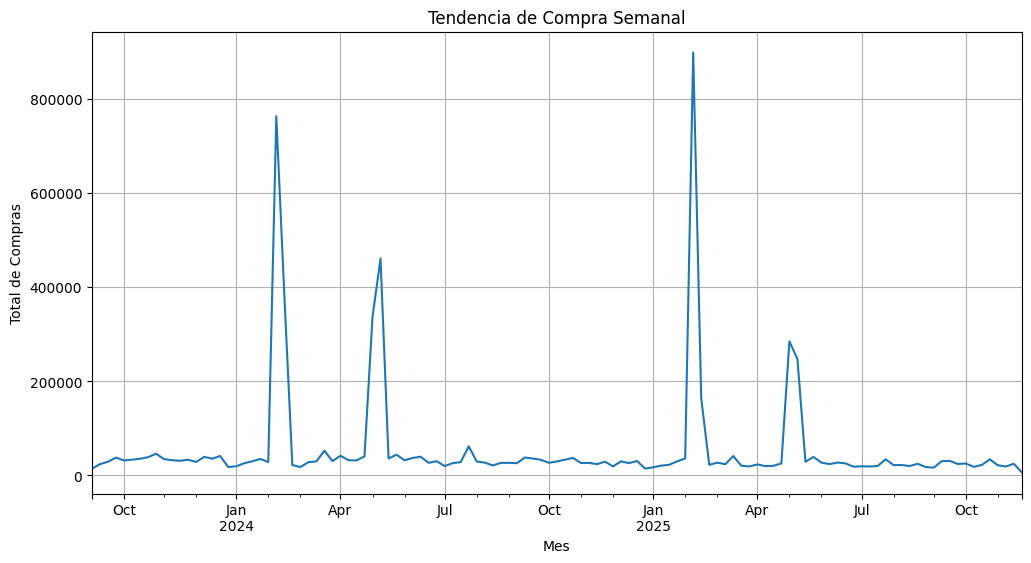

In [16]:
# Tendencia de venta a lo largo de los meses
monthly_trend = grouped.set_index('fecha_vuelo')

# Re-muestrear por mes y sumar el 'total'
monthly_trend = monthly_trend['total'].resample('W').sum()

# Gráfica
plt.figure(figsize=(12, 6))
monthly_trend.plot(kind='line')
plt.title('Tendencia de Compra Semanal')
plt.xlabel('Mes')
plt.ylabel('Total de Compras')
plt.grid(True)
plt.show()

### **5. RFM Estacional**

##### 5.1 Creación Variables

In [17]:
# Recency
fecha_max = df_filtered['fecha_vuelo'].max() #+ pd.Timedelta(days=1)
print(f"Fecha Máxima: {fecha_max.date()}")
recency_rfm = df_filtered.groupby('cliente_id')['fecha_vuelo'].max().reset_index()
recency_rfm['recency_dias'] = (fecha_max - recency_rfm['fecha_vuelo']).dt.days

# Frequency
frecuencia_rfm = df_filtered.groupby('cliente_id').agg(Frequency=('numero_orden', 'nunique')).reset_index()

# Monetary
monetary_rfm = df_filtered.groupby('cliente_id')['total'].sum().reset_index()
monetary_rfm.columns = ['cliente_id', 'total_gasto_cliente']

# Estacionalidad — semanas pico

# METODO 1
semanas_pico = [5,6,7,18,19]
matriz_semanas = df_filtered.pivot_table(
    index='cliente_id',
    columns='semana',
    values='numero_orden',
    aggfunc='count',
    fill_value=0
).reset_index()

# Peso de semanas pico
matriz_semanas['compras_pico'] = matriz_semanas[semanas_pico].sum(axis=1)
matriz_semanas['compras_totales'] = matriz_semanas.drop(columns=['cliente_id']).sum(axis=1)
matriz_semanas['peso_picos'] = (matriz_semanas['compras_pico'] / matriz_semanas['compras_totales']).fillna(0)


# METODO 2
# def es_fecha_pico(numero_semana):
#     if (numero_semana in [5,6,7]) or (numero_semana in [18,19]):
#         return 1
#     return 0

# df_filtered['peso_picos'] = df_filtered['semana'].apply(es_fecha_pico)
# estacional_rfm = df_filtered.groupby('cliente_id')['peso_picos'].mean().reset_index()
# estacional_rfm.columns = ['cliente_id', 'peso_picos']

Fecha Máxima: 2025-11-19


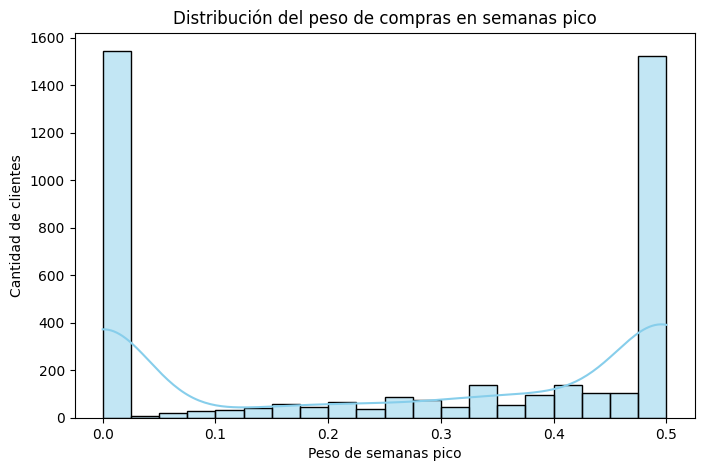

In [18]:
plt.figure(figsize=(8,5))
sns.histplot(matriz_semanas['peso_picos'], bins=20, kde=True, color='skyblue')
plt.title('Distribución del peso de compras en semanas pico')
plt.xlabel('Peso de semanas pico')
plt.ylabel('Cantidad de clientes')
plt.show()


In [19]:
# Merge RFM + estacionalidad
# METODO 1
rfm_df = recency_rfm[['cliente_id','recency_dias']] \
    .merge(frecuencia_rfm, on='cliente_id') \
    .merge(monetary_rfm, on='cliente_id') \
    .merge(matriz_semanas[['cliente_id','peso_picos']], on='cliente_id')

# METODO 2
# rfm_df = recency_rfm[['cliente_id','recency_dias']] \
#     .merge(frecuencia_rfm, on='cliente_id') \
#     .merge(monetary_rfm, on='cliente_id') \
#     .merge(estacional_rfm[['cliente_id','peso_picos']], on='cliente_id')

rfm_df.rename(columns={'recency_dias': 'recency', 'Frequency': 'frequency', 'total_gasto_cliente': 'monetary', 'peso_picos': 'estacional'}, inplace=True)

# METODO 1
rfm_df['estacional'] = rfm_df['estacional']

# METODO 2
# rfm_df['estacional'] = rfm_df['estacional'].astype(int, errors='ignore')

In [20]:
rfm_df.head(20)

cliente_id  recency  frequency  monetary  estacional
0            2      549          1    121.50    0.000000
1            3      797          1     71.00    0.000000
2            4      733          4   1847.04    0.000000
3            8      283          2    629.75    0.500000
4           11      649          1   1128.00    0.500000
5           15      558          3    435.45    0.416667
6           18      650          2    762.75    0.375000
7           26       94         16   7806.35    0.229167
8           27      437          6   2009.43    0.000000
9           29        4         80  22101.17    0.084906
10          32      747          1    231.26    0.000000
11          34      549          5   2502.51    0.451613
12          36      283          4   2435.25    0.500000
13          38      434          6   1055.46    0.136364
14          42      544         10   2761.78    0.180000
15          43      108         15   2159.99    0.244444
16          44      563          3   1678.20    0.500000
17          45      646          1    256.50    0.500000
18          46        3         88  31323.69    0.194888
19          48      563          3   3577.92    0.500000

In [21]:
# rfm_df.to_csv('sample_data/rfm_df.csv', index=False)

##### 5.2 Analisis Estadistico

In [22]:
rfm_df.head()

cliente_id  recency  frequency  monetary  estacional
0           2      549          1    121.50         0.0
1           3      797          1     71.00         0.0
2           4      733          4   1847.04         0.0
3           8      283          2    629.75         0.5
4          11      649          1   1128.00         0.5

In [23]:
describe_rfm = rfm_df.describe()
describe_rfm

cliente_id      recency    frequency       monetary   estacional
count  4250.000000  4250.000000  4250.000000    4250.000000  4250.000000
mean   3807.701882   376.184471     4.282588    1556.490305     0.265117
std    2093.408729   223.177766    12.371967    5644.322796     0.222077
min       2.000000     0.000000     1.000000      52.250000     0.000000
25%    2033.000000   198.000000     1.000000     175.155000     0.000000
50%    3829.000000   304.000000     1.000000     431.895000     0.333333
75%    5563.750000   563.000000     3.000000    1152.912500     0.500000
max    7561.000000   814.000000   244.000000  184044.120000     0.500000

###### Recencia


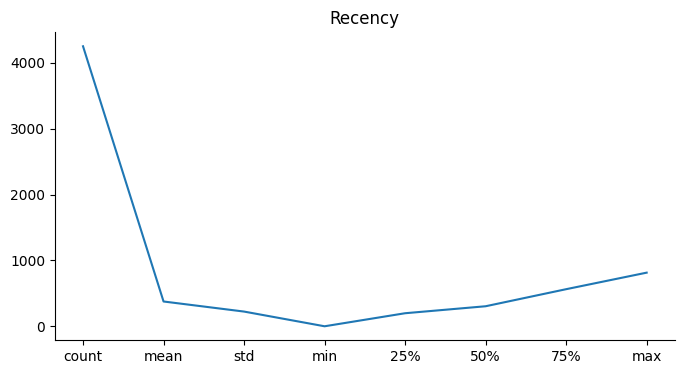

In [24]:
# Grafico estadistico Recencia
describe_rfm['recency'].plot(kind='line', figsize=(8, 4), title='Recency')
plt.gca().spines[['top', 'right']].set_visible(False)

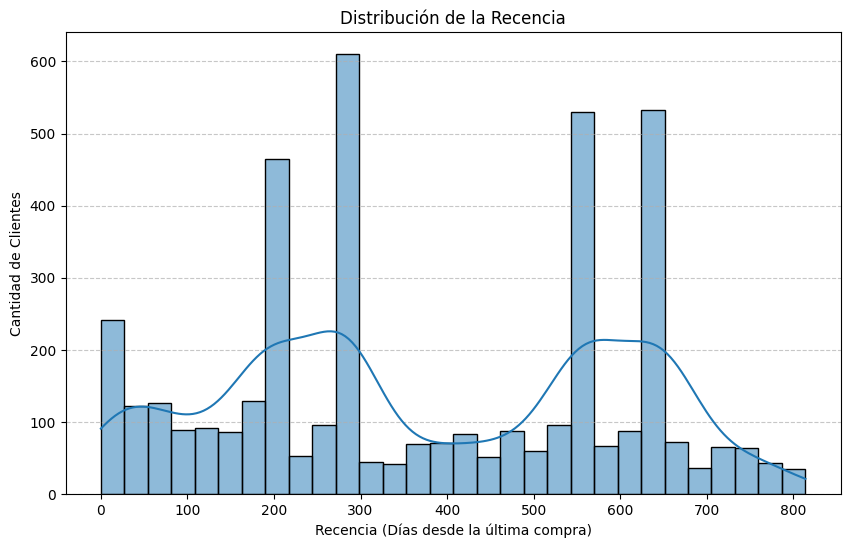

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(rfm_df['recency'], bins=30, kde=True)
plt.title('Distribución de la Recencia')
plt.xlabel('Recencia (Días desde la última compra)')
plt.ylabel('Cantidad de Clientes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

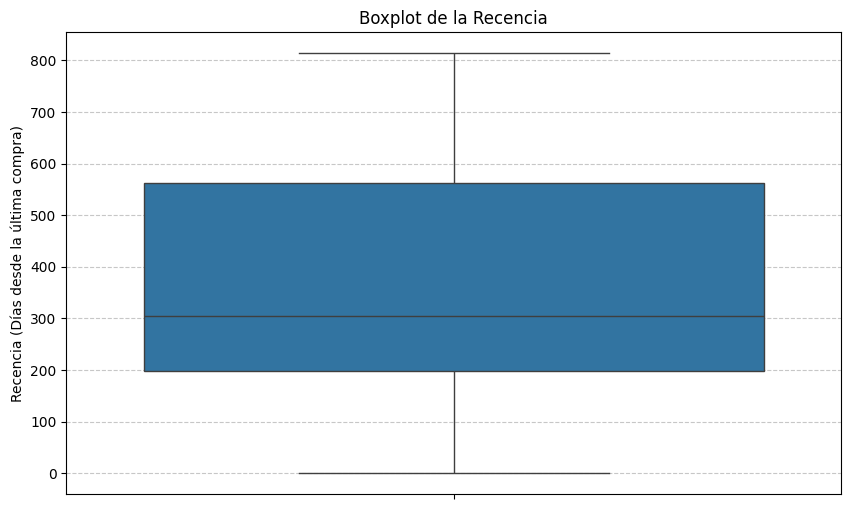

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=rfm_df['recency'])
plt.title('Boxplot de la Recencia')
plt.ylabel('Recencia (Días desde la última compra)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

###### Frecuencia

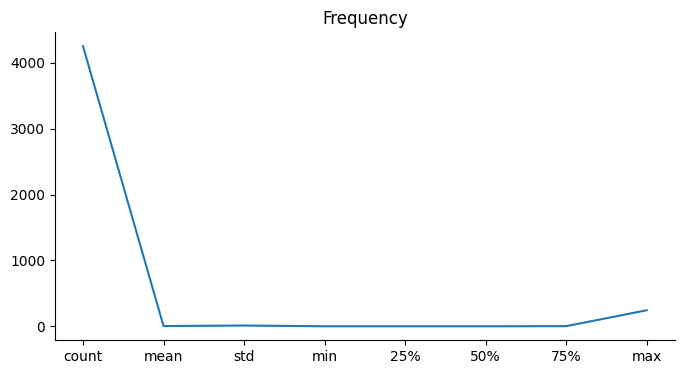

In [27]:
# Grafico estadistico Frecuencia
describe_rfm['frequency'].plot(kind='line', figsize=(8, 4), title='Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)

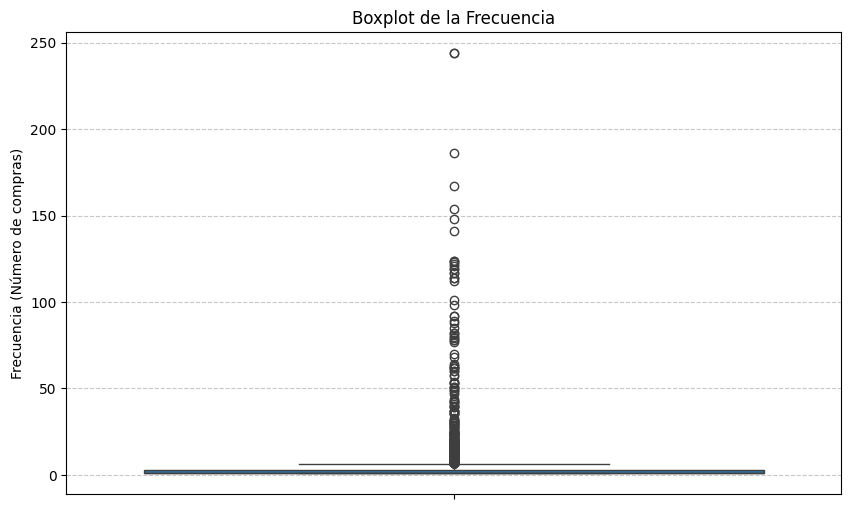

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=rfm_df['frequency'])
plt.title('Boxplot de la Frecuencia')
plt.ylabel('Frecuencia (Número de compras)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

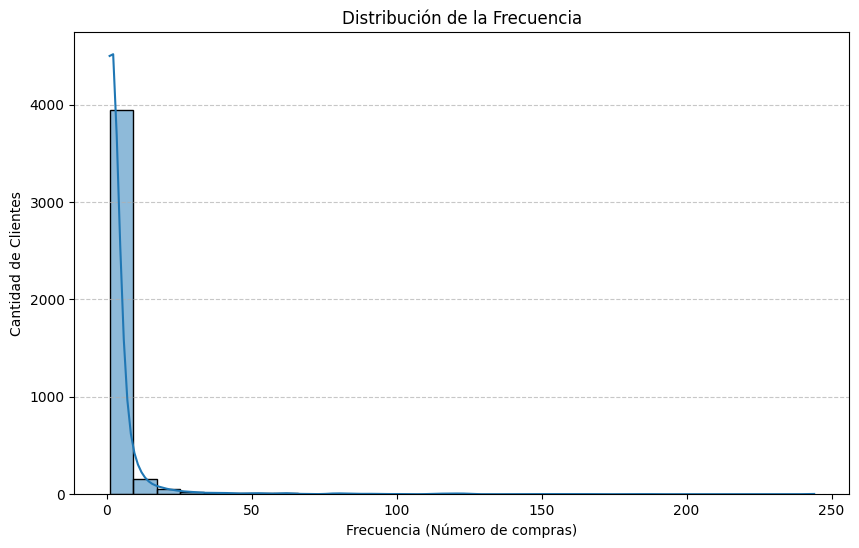

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(rfm_df['frequency'], bins=30, kde=True)
plt.title('Distribución de la Frecuencia')
plt.xlabel('Frecuencia (Número de compras)')
plt.ylabel('Cantidad de Clientes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

###### Monetario

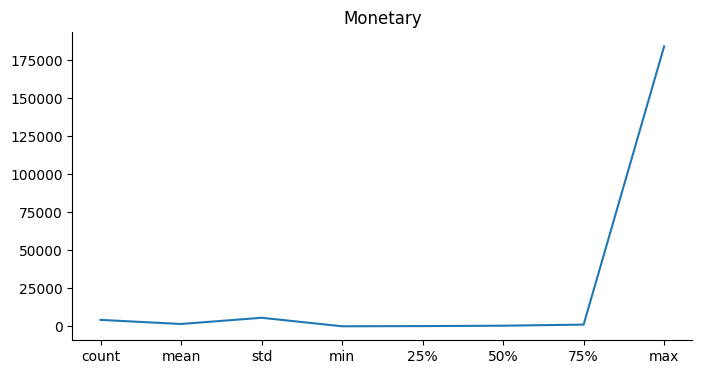

In [30]:
# Grafico estadistico Monetario
describe_rfm['monetary'].plot(kind='line', figsize=(8, 4), title='Monetary')
plt.gca().spines[['top', 'right']].set_visible(False)

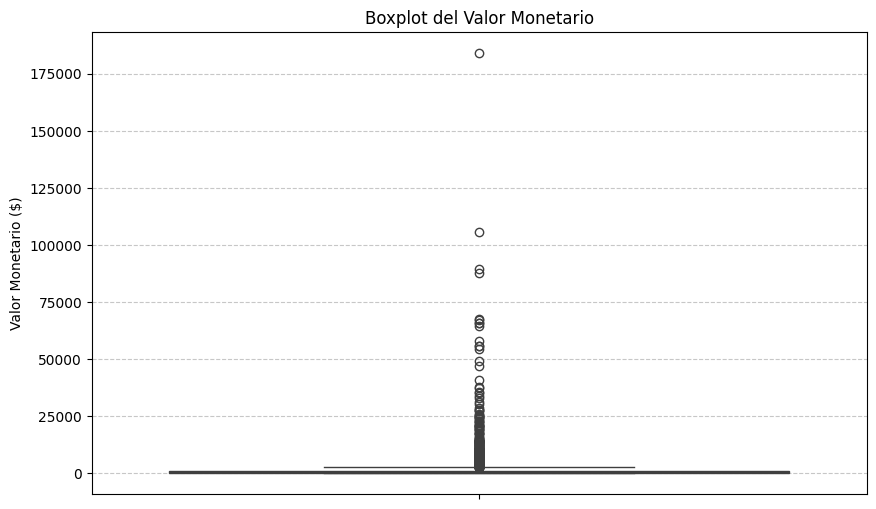

In [31]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=rfm_df['monetary'])
plt.title('Boxplot del Valor Monetario')
plt.ylabel('Valor Monetario ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

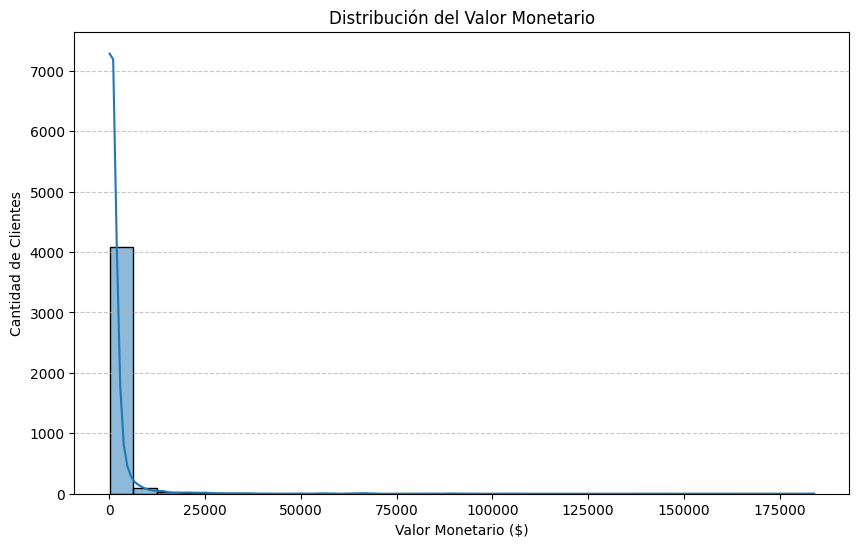

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(rfm_df['monetary'], bins=30, kde=True)
plt.title('Distribución del Valor Monetario')
plt.xlabel('Valor Monetario ($)')
plt.ylabel('Cantidad de Clientes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### **6. Preparación Datos**

#### 6.1 Transformación y Escalamiento de Datos

In [33]:
# Transformación Logaritmica
rfm_df['recency_log'] = -np.log1p(rfm_df['recency'])
rfm_df['frequency_log'] = np.log1p(rfm_df['frequency'])
rfm_df['monetary_log'] = np.log1p(rfm_df['monetary'])

# METODO 1
rfm_df['estacional_log'] = np.log1p(rfm_df['estacional'] * 100 + 1)  # amplifica importancia

# METODO 2
# rfm_df['estacional_log'] = np.log1p(rfm_df['estacional'])
rfm_df.head(10)

cliente_id  recency  frequency  monetary  estacional  recency_log  \
0           2      549          1    121.50    0.000000    -6.309918   
1           3      797          1     71.00    0.000000    -6.682109   
2           4      733          4   1847.04    0.000000    -6.598509   
3           8      283          2    629.75    0.500000    -5.648974   
4          11      649          1   1128.00    0.500000    -6.476972   
5          15      558          3    435.45    0.416667    -6.326149   
6          18      650          2    762.75    0.375000    -6.478510   
7          26       94         16   7806.35    0.229167    -4.553877   
8          27      437          6   2009.43    0.000000    -6.082219   
9          29        4         80  22101.17    0.084906    -1.609438   

   frequency_log  monetary_log  estacional_log  
0       0.693147      4.808111        0.693147  
1       0.693147      4.276666        0.693147  
2       1.609438      7.521881        0.693147  
3       1.098612      6.446910        3.951244  
4       0.693147      7.029088        3.951244  
5       1.386294      6.078674        3.776585  
6       1.098612      6.638241        3.676301  
7       2.833213      8.962821        3.215537  
8       1.945910      7.606104        0.693147  
9       4.394449     10.003431        2.350476

In [34]:
# Seleccion de caracteristicas
cols_modelo = ['recency_log','frequency_log','monetary_log','estacional_log']

# Escalar
scaler = StandardScaler()
X = scaler.fit_transform(rfm_df[cols_modelo])

X

array([[-0.6519566 , -0.6768338 , -1.12245686, -1.29513928],
       [-0.98568048, -0.6768338 , -1.53972935, -1.29513928],
       [-0.91072105,  0.58742555,  1.00830303, -1.29513928],
       ...,
       [ 3.14129384, -0.6768338 , -0.84240781, -1.29513928],
       [ 3.56272187, -0.6768338 , -0.91769092, -1.29513928],
       [ 5.00582189, -0.6768338 , -0.91769092, -1.29513928]])

#### 6.2 Analisis Estadistico post transformacion logaritmica

Text(0, 0.5, 'Cantidad de Clientes')

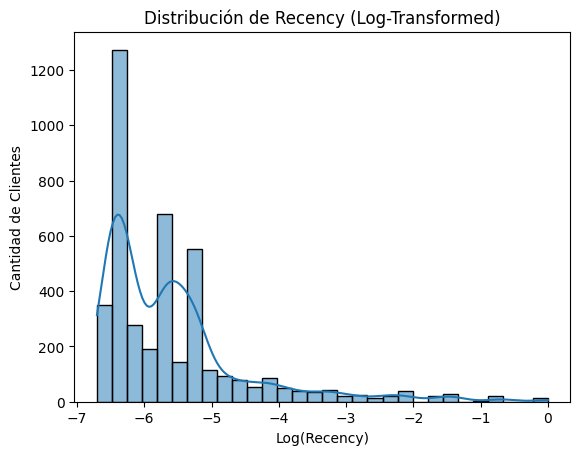

In [35]:
# Histograma para Recency (log-transformed)
plt.subplot(1, 1, 1)
sns.histplot(rfm_df['recency_log'], bins=30, kde=True)
plt.title('Distribución de Recency (Log-Transformed)')
plt.xlabel('Log(Recency)')
plt.ylabel('Cantidad de Clientes')



Text(0, 0.5, 'Cantidad de Clientes')

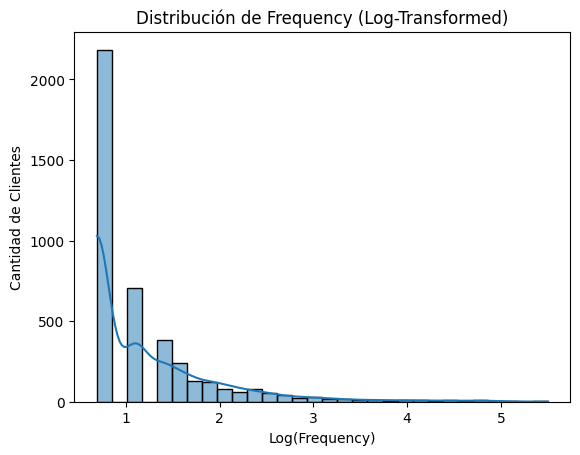

In [36]:
# Histograma para Frequency (log-transformed)
plt.subplot(1, 1 ,1)
sns.histplot(rfm_df['frequency_log'], bins=30, kde=True)
plt.title('Distribución de Frequency (Log-Transformed)')
plt.xlabel('Log(Frequency)')
plt.ylabel('Cantidad de Clientes')



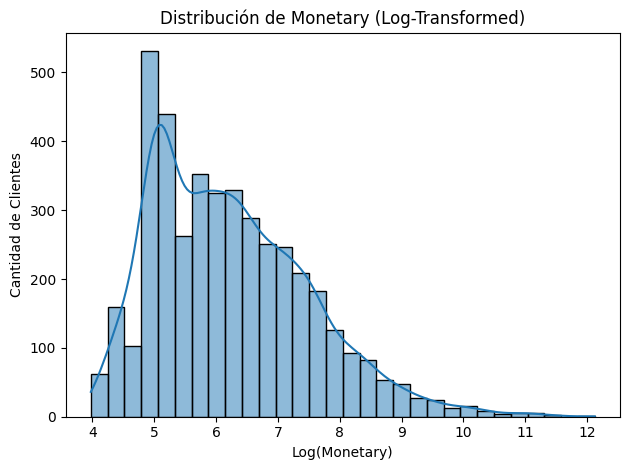

In [37]:
# Histograma para Monetary (log-transformed)
plt.subplot(1, 1, 1)
sns.histplot(rfm_df['monetary_log'], bins=30, kde=True)
plt.title('Distribución de Monetary (Log-Transformed)')
plt.xlabel('Log(Monetary)')
plt.ylabel('Cantidad de Clientes')

plt.tight_layout()
plt.show()

### **7. Selección de k óptimo**

#### 7.1 Método del codo

In [38]:
# Calculo la inercia para k de 2 a 10
inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X)
    inertia.append(kmeans.inertia_)
    print(f"{kmeans.inertia_}")


11005.317558152012
6793.064745239683
5304.5486756225955
4232.536231166638
3646.249243063738
3386.538202465199
3071.6768521669833
2862.9130067334504
2552.638739129757


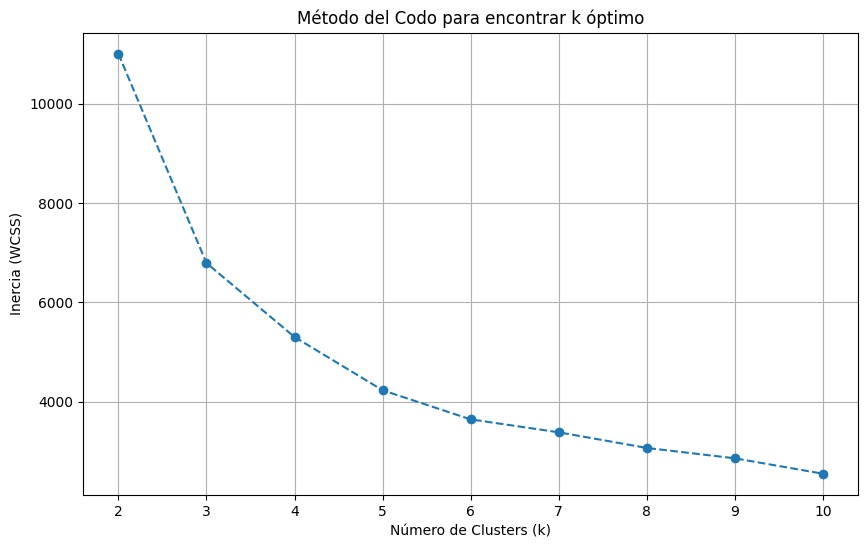

In [39]:
# Graficar el Método del Codo
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia (WCSS)')
plt.title('Método del Codo para encontrar k óptimo')
plt.xticks(K_range)
plt.grid(True)
plt.show()

#### 7.2 Método de Silhouette Score

k=2 -> Silhouette Score: 0.4032
k=3 -> Silhouette Score: 0.4570
k=4 -> Silhouette Score: 0.4398
k=5 -> Silhouette Score: 0.4541
k=6 -> Silhouette Score: 0.4036
k=7 -> Silhouette Score: 0.3607
k=8 -> Silhouette Score: 0.3577
k=9 -> Silhouette Score: 0.3621
k=10 -> Silhouette Score: 0.3497


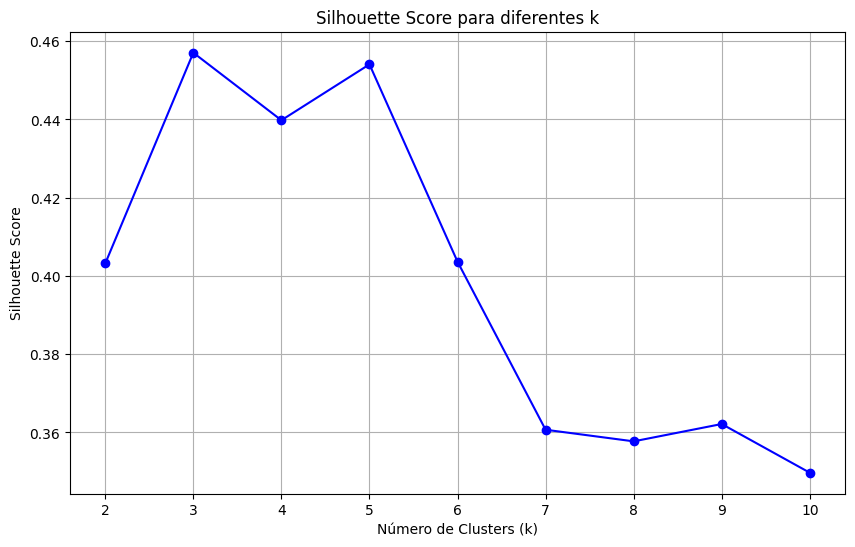

In [40]:
# Rango de k a probar
K_range = range(2, 11)
silhouette_scores = []

for k in K_range:
    # Entrenamos el modelo temporal
    kmeans = KMeans(n_clusters=k, random_state=24, n_init="auto")
    labels = kmeans.fit_predict(X)

    # Calculamos silueta
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)
    print(f"k={k} -> Silhouette Score: {score:.4f}")

# Grafico
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para diferentes k')
plt.grid(True)
plt.show()

### **8. Modelamiento KMEANS**

In [41]:
# Aplicar K-Means con el K óptimo
k_optimal = 5

kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init="auto")
kmeans.fit(X)

# Asignar las etiquetas del cluster de nuevo al dataframe
rfm_df['cluster'] = kmeans.labels_

In [42]:
# Analizar los Clusters
# Calcular la media de R, F, M, E para cada cluster
cluster_analysis = rfm_df.groupby('cluster')[['recency', 'frequency', 'monetary', 'estacional']].mean()
#
# Añadir el conteo de clientes en cada cluster
cluster_analysis['count'] = rfm_df['cluster'].value_counts()

# Reordenar columnas y ordenar por Valor Monetario para facilitar la interpretación
cluster_analysis = cluster_analysis[['count', 'recency', 'frequency', 'monetary', 'estacional']].sort_values(by='cluster', ascending=False)
cluster_analysis['estacional'] = cluster_analysis['estacional'].apply(lambda x: round(x, 2))
# Imprimir el análisis
print("Análisis de Clusters".center(70, '-'))
print(cluster_analysis)

-------------------------Análisis de Clusters-------------------------
         count     recency  frequency      monetary  estacional
cluster                                                        
4          174   36.339080  44.327586  16702.101562        0.18
3         1224  472.904412   1.302288    259.741597        0.00
2          906  272.974614   6.462472   2679.479502        0.35
1          301   48.910299   2.029900    370.770764        0.02
0         1645  456.893009   1.475988    517.801812        0.47


### **9. Analisis de Resultados**

In [43]:
# Silhouette Score
score = silhouette_score(X, kmeans.labels_)
print(f'Silhouette Score para k=5: {score:.4f}')

Silhouette Score para k=5: 0.4549


In [44]:
# Davies-Bouldin
db_score = davies_bouldin_score(X, kmeans.labels_)
print(f'Davies-Bouldin Score para k=5: {db_score:.3f}')

Davies-Bouldin Score para k=5: 0.854


In [45]:
mapeo_clientes = {
    4: 'Clientes Estratégicos (VIP)',
    3: 'Clientes Inactivos',
    2: 'Cliente en Riesgo',
    1: 'Clientes Nuevos',
    0: 'Clientes Estacionales',
}
cluster_analysis = cluster_analysis.rename(index=mapeo_clientes)
cluster_analysis = cluster_analysis.reset_index()

### **10. Visualización**

#### 10.1 Analisis de cluster

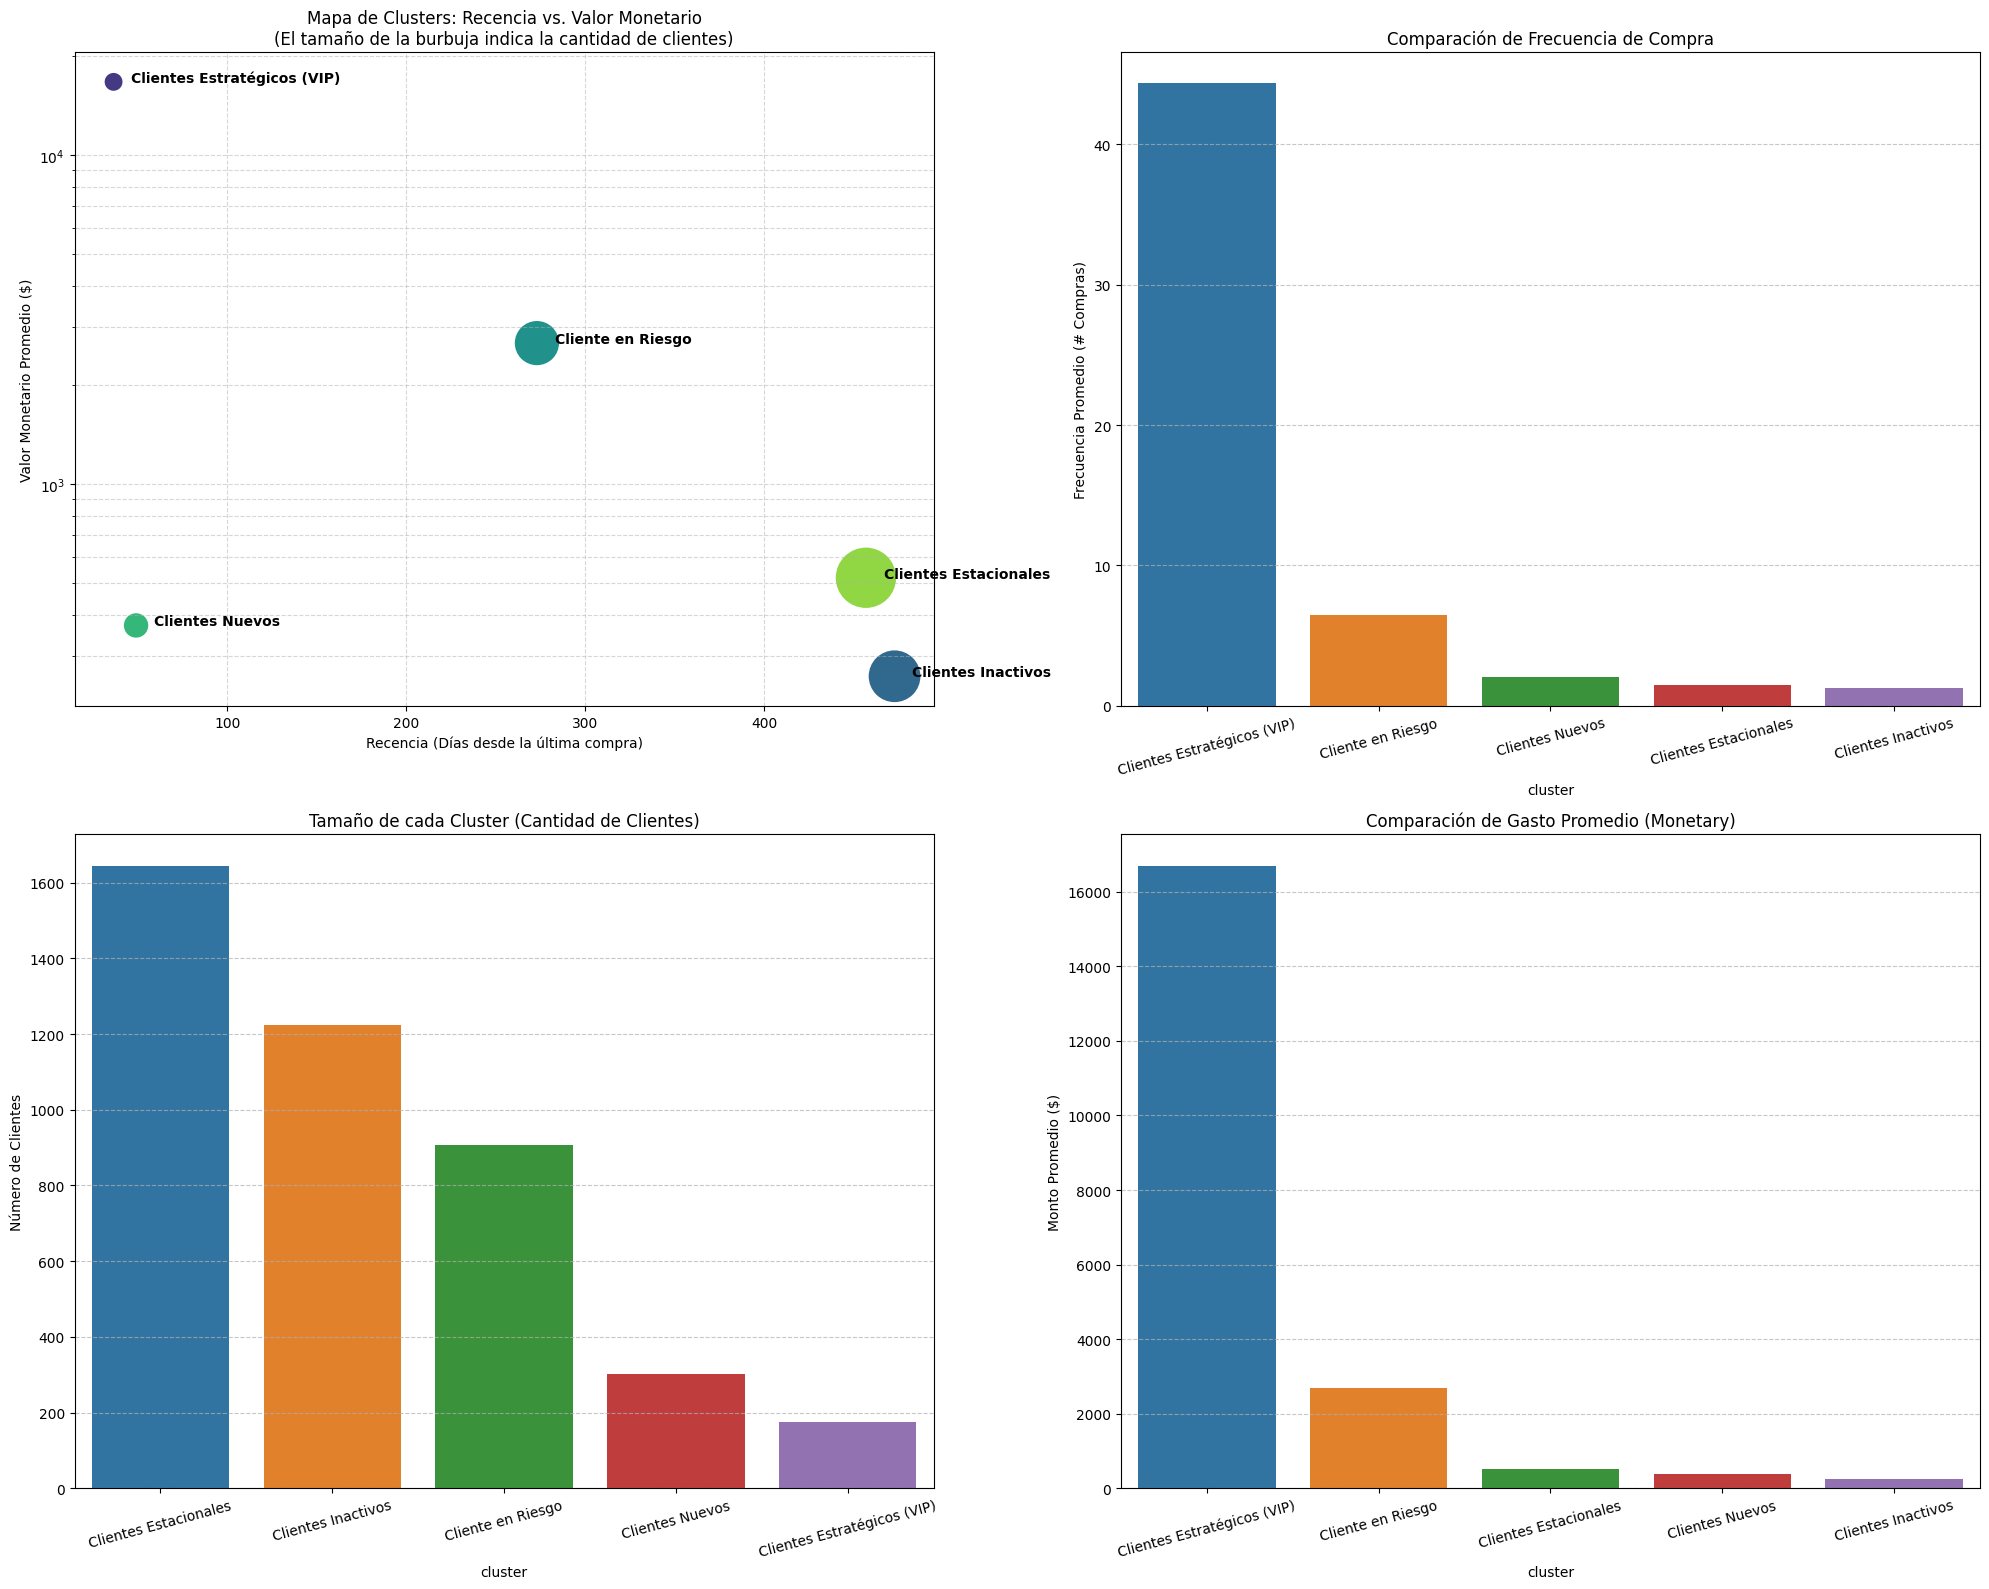

In [46]:
plt.figure(figsize=(20, 16))

# Gráfico de Burbujas: Recencia vs. Monto (Tamaño = Cantidad de Clientes)
# Usamos escala logarítmica para el Monto porque el VIP es muy alto
plt.subplot(2, 2, 1)
sns.scatterplot(data=cluster_analysis, x='recency', y='monetary', size='count', hue='cluster', sizes=(200, 2000),
                legend=False, palette='viridis')

# Etiquetas para los puntos
for i in range(cluster_analysis.shape[0]):
    plt.text(cluster_analysis.recency[i] + 10, cluster_analysis.monetary[i], cluster_analysis.cluster[i],
             horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.title('Mapa de Clusters: Recencia vs. Valor Monetario\n(El tamaño de la burbuja indica la cantidad de clientes)', fontsize=12)
plt.xlabel('Recencia (Días desde la última compra)')
plt.ylabel('Valor Monetario Promedio ($)')
plt.yscale('log')  # Escala logarítmica para ver mejor las diferencias
plt.grid(True, which="both", ls="--", alpha=0.5)

# 2. Gráfico de Barras: Frecuencia de Compra
plt.subplot(2, 2, 2)
sns.barplot(data=cluster_analysis.sort_values('frequency', ascending=False), x='cluster', y='frequency', legend=False, hue='cluster')
plt.title('Comparación de Frecuencia de Compra', fontsize=12)
plt.ylabel('Frecuencia Promedio (# Compras)')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 3. Gráfico de Barras: Cantidad de Clientes (Tamaño del Cluster)
plt.subplot(2, 2, 3)
sns.barplot(data=cluster_analysis.sort_values('count', ascending=False), x='cluster', y='count', legend=False, hue='cluster')
plt.title('Tamaño de cada Cluster (Cantidad de Clientes)', fontsize=12)
plt.ylabel('Número de Clientes')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 4. Gráfico de Barras: Valor Monetario
plt.subplot(2, 2, 4)
sns.barplot(data=cluster_analysis.sort_values('monetary', ascending=False), x='cluster', y='monetary', legend=False, hue='cluster')
plt.title('Comparación de Gasto Promedio (Monetary)', fontsize=12)
plt.ylabel('Monto Promedio ($)')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

#### 10.2 Analisis de clientes en cluster

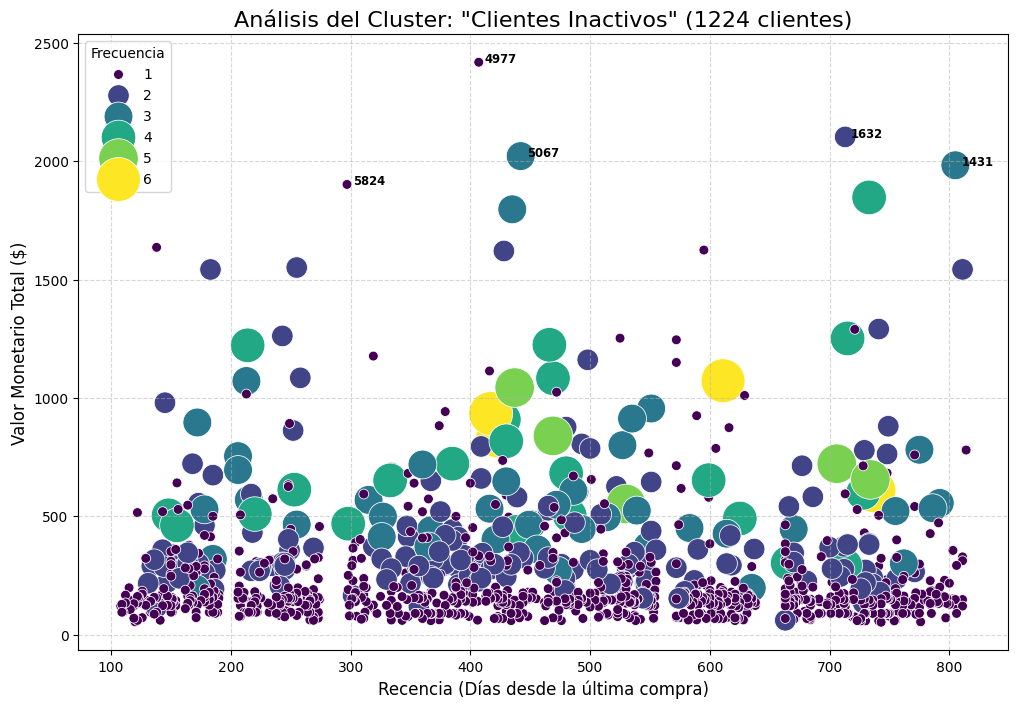

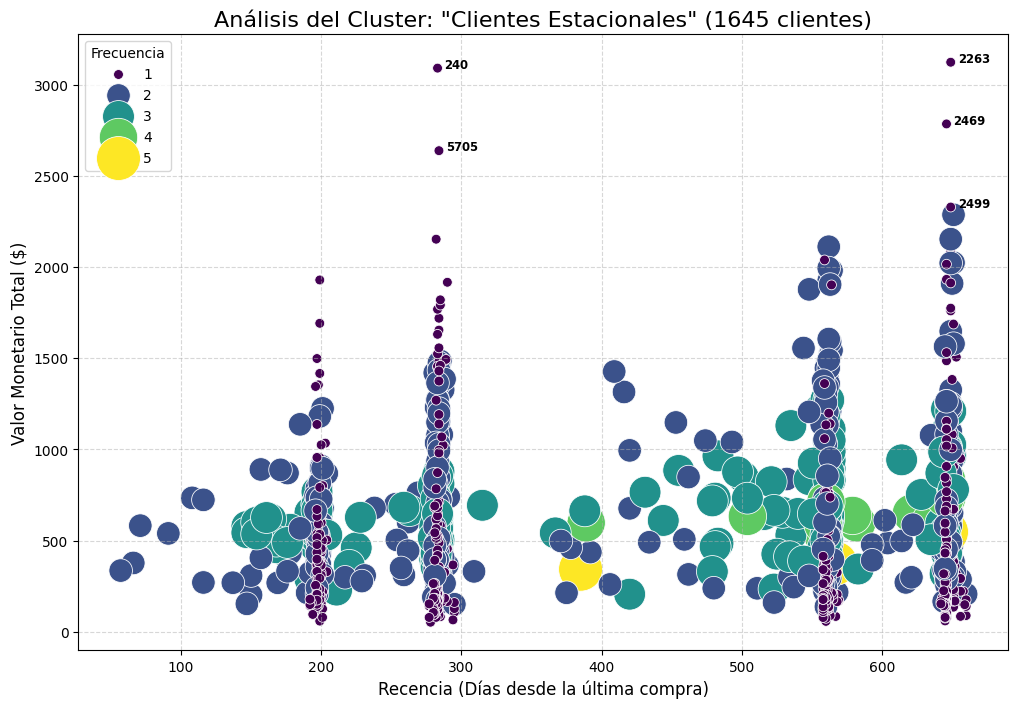

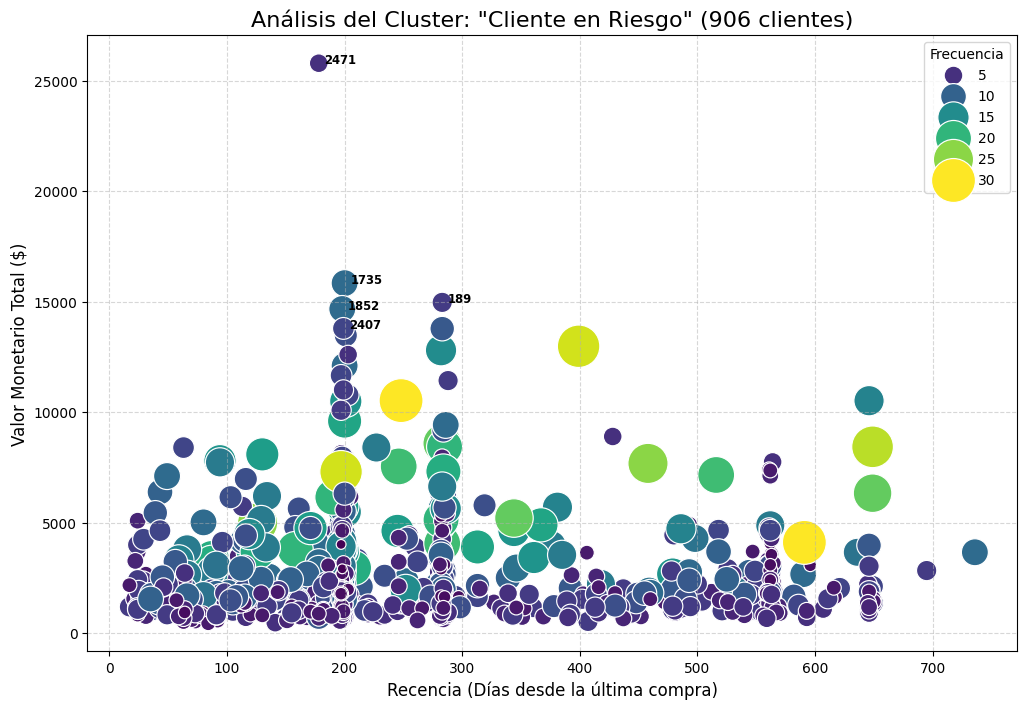

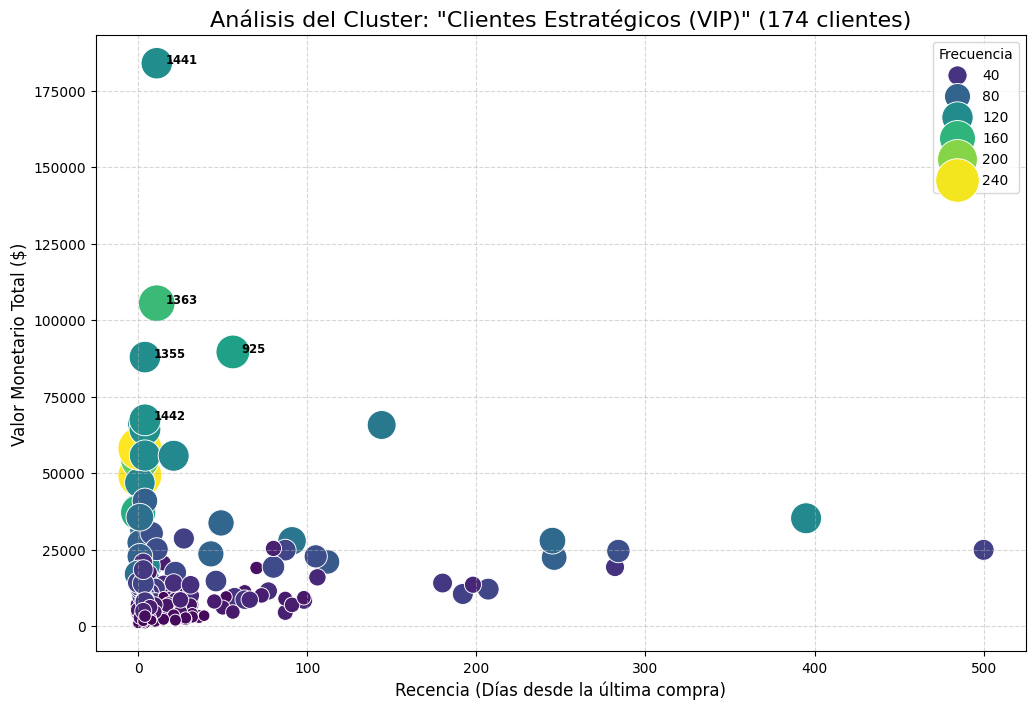

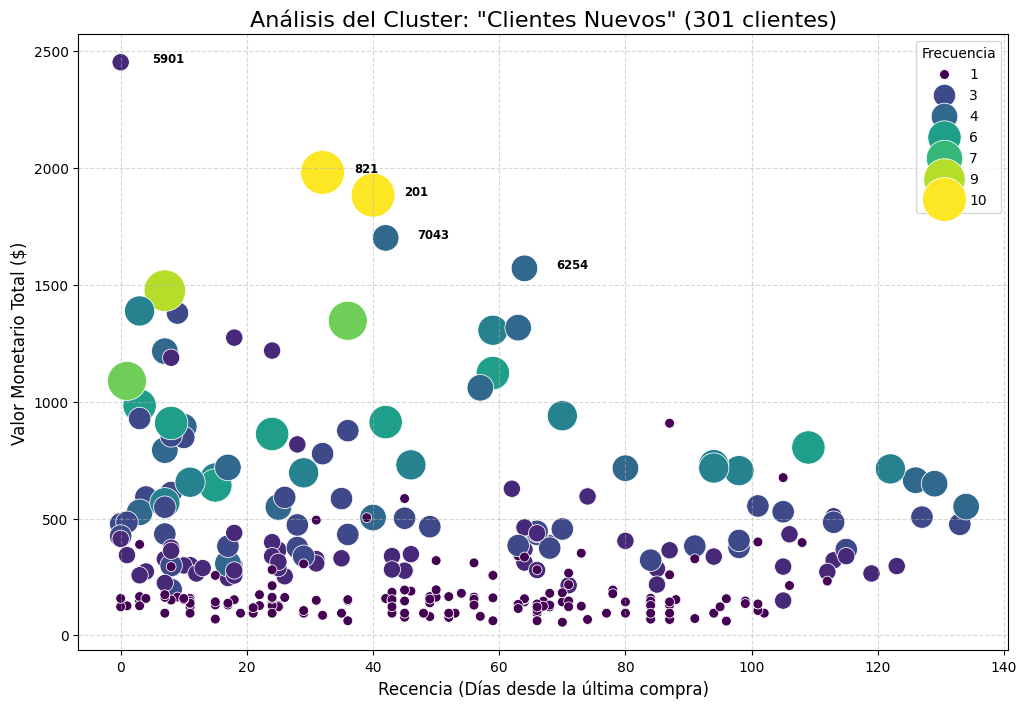

In [47]:
# --- Visualización Individual de Clusters ---

# Mapear los números de cluster a los nombres descriptivos en el dataframe principal
rfm_df['Cluster_Name'] = rfm_df['cluster'].map(mapeo_clientes)

# Obtener los nombres únicos de los clusters
cluster_names = rfm_df['Cluster_Name'].unique()

for cluster_name in cluster_names:
    if pd.isna(cluster_name):
        continue

    # Filtrar los datos para el cluster actual
    cluster_data = rfm_df[rfm_df['Cluster_Name'] == cluster_name]

    plt.figure(figsize=(12, 8))

    # Grafico de dispersión para el cluster actual
    sns.scatterplot(
        data=cluster_data,
        x='recency',
        y='monetary',
        size='frequency',
        hue='frequency',
        sizes=(50, 1000),
        palette='viridis',
        legend='auto'
    )

    plt.title(f'Análisis del Cluster: "{cluster_name}" ({len(cluster_data)} clientes)', fontsize=16)
    plt.xlabel('Recencia (Días desde la última compra)', fontsize=12)
    plt.ylabel('Valor Monetario Total ($)', fontsize=12)
    plt.grid(True, which="both", ls="--", alpha=0.5)

    # Anotar algunos clientes para identificación
    top_clients = cluster_data.nlargest(5, 'monetary')

    for index, row in top_clients.iterrows():
        plt.text(row['recency'] + 5, row['monetary'], str(int(row['cliente_id'])),
                 horizontalalignment='left', size='small', color='black', weight='semibold')

    plt.legend(title='Frecuencia')
    plt.show()

#### 10.3 Widget Interactivo para Filtro de Clientes por Cluster

In [48]:
# Usar df_model y la columna cluster generada
cluster_options = sorted(rfm_df['cluster'].unique())

# Columnas que quieres mostrar en el promedio
cols_to_scale = ['recency', 'frequency', 'monetary', 'estacional']

dropdown = widgets.Dropdown(
    options=cluster_options,
    description='Cluster:',
    value=cluster_options[0]
)

def show_cluster_info(selected_cluster):
    df_cluster = rfm_df[rfm_df['cluster'] == selected_cluster]
    print("\n\n")

    print(f"Cluster seleccionado: {selected_cluster} - {mapeo_clientes.get(selected_cluster)}")
    print(f"Número de clientes: {df_cluster.shape[0]}")

    print("\n\n")
    print("Promedios de RFM".center(70, '-'))
    print(df_cluster[cols_to_scale].mean().round(2))

    print("\n\n")
    print("Primeros 10 clientes".center(70, '-'))
    print(df_cluster[['cliente_id', 'recency', 'frequency', 'monetary', 'estacional', 'cluster']].head(10))
    print("\n\n")

widgets.interact(show_cluster_info, selected_cluster=dropdown)

interactive(children=(Dropdown(description='Cluster:', options=(np.int32(0), np.int32(1), np.int32(2), np.int3…

<function __main__.show_cluster_info(selected_cluster)>

#### 10.4 Analisis de Componentes Principales

In [49]:
# ---------------------------------------------------------
# PCA (asegurar que PC1 y PC2 existan en df_model)
# ---------------------------------------------------------
# Variables usadas para PCA (ajusta si tus columnas tienen otros nombres)
vars_pca = ['recency_log','frequency_log','monetary_log','estacional_log']

pca = PCA(n_components=2)
pcs = pca.fit_transform(rfm_df[vars_pca])

rfm_df['PC1'] = pcs[:, 0]
rfm_df['PC2'] = pcs[:, 1]

print("Columnas actuales del df_model:", rfm_df.columns)


Columnas actuales del df_model: Index(['cliente_id', 'recency', 'frequency', 'monetary', 'estacional',
       'recency_log', 'frequency_log', 'monetary_log', 'estacional_log',
       'cluster', 'Cluster_Name', 'PC1', 'PC2'],
      dtype='object')


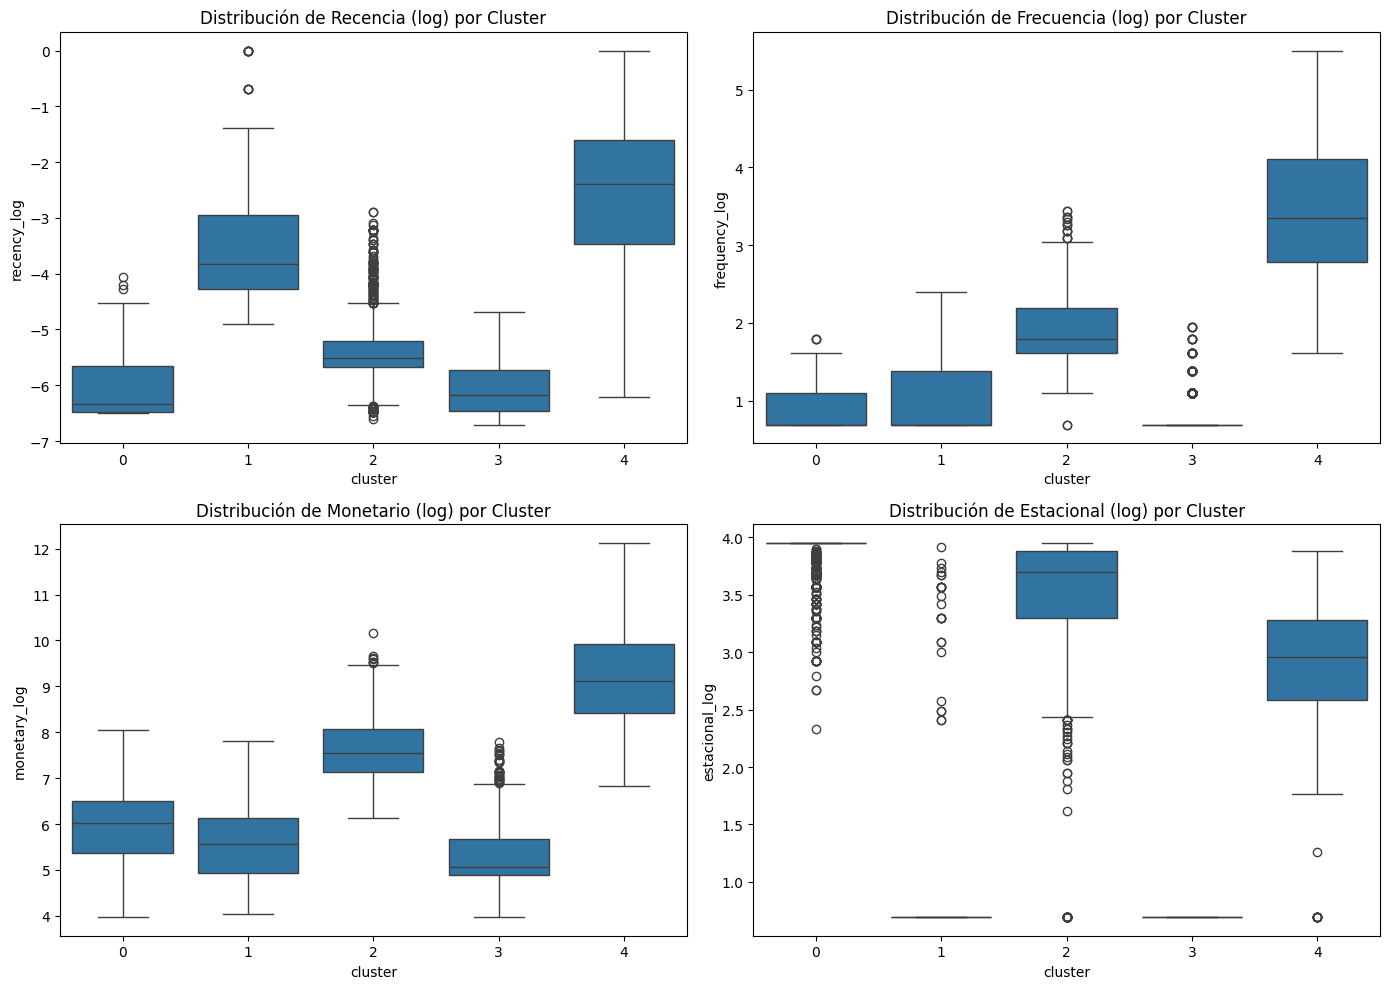

In [50]:
# ---------------------------------------------------------
# DISTRIBUCIONES POR CLUSTER
# ---------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14,10))
variables = ['recency_log','frequency_log','monetary_log','estacional_log']
titles = ['Recencia (log)', 'Frecuencia (log)', 'Monetario (log)', 'Estacional (log)']

for ax, var, title in zip(axes.flatten(), variables, titles):
    sns.boxplot(data=rfm_df, x='cluster', y=var, ax=ax)
    ax.set_title(f'Distribución de {title} por Cluster')

plt.tight_layout()
plt.show()

In [51]:
# ---------------------------------------------------------
# INSIGHTS AUTOMÁTICOS POR CLUSTER
# ---------------------------------------------------------
print("\nINSIGHTS AUTOMÁTICOS POR CLUSTER\n")

def interpretar_cluster_stats(df_cluster):
    insights = []

    # Recency
    if df_cluster['recency'] < rfm_df['recency'].median():
        insights.append("Clientes recientes")
    else:
        insights.append("Clientes inactivos")

    # Frequency
    if df_cluster['frequency'] > rfm_df['frequency'].median():
        insights.append("Alta frecuencia")
    else:
        insights.append("Frecuencia baja/media")

    # Monetary
    if df_cluster['monetary'] > rfm_df['monetary'].median():
        insights.append("Alto valor monetario")
    else:
        insights.append("Gasto bajo/medio")

    # Estacionalidad
    if df_cluster['estacional'] > rfm_df['estacional'].median():
        insights.append("Muy estacionales (picos)")
    else:
        insights.append("No estacionales")

    return " / ".join(insights)


# Crear insights por cluster
cluster_insights = (
    rfm_df.groupby('cluster')[['recency','frequency','monetary','estacional']]
    .mean()
    .apply(interpretar_cluster_stats, axis=1)
)

for c, desc in cluster_insights.items():
    print(f"➡ Cluster {c}: {desc}")


INSIGHTS AUTOMÁTICOS POR CLUSTER

➡ Cluster 0: Clientes inactivos / Alta frecuencia / Alto valor monetario / Muy estacionales (picos)
➡ Cluster 1: Clientes recientes / Alta frecuencia / Gasto bajo/medio / No estacionales
➡ Cluster 2: Clientes recientes / Alta frecuencia / Alto valor monetario / Muy estacionales (picos)
➡ Cluster 3: Clientes inactivos / Alta frecuencia / Gasto bajo/medio / No estacionales
➡ Cluster 4: Clientes recientes / Alta frecuencia / Alto valor monetario / No estacionales


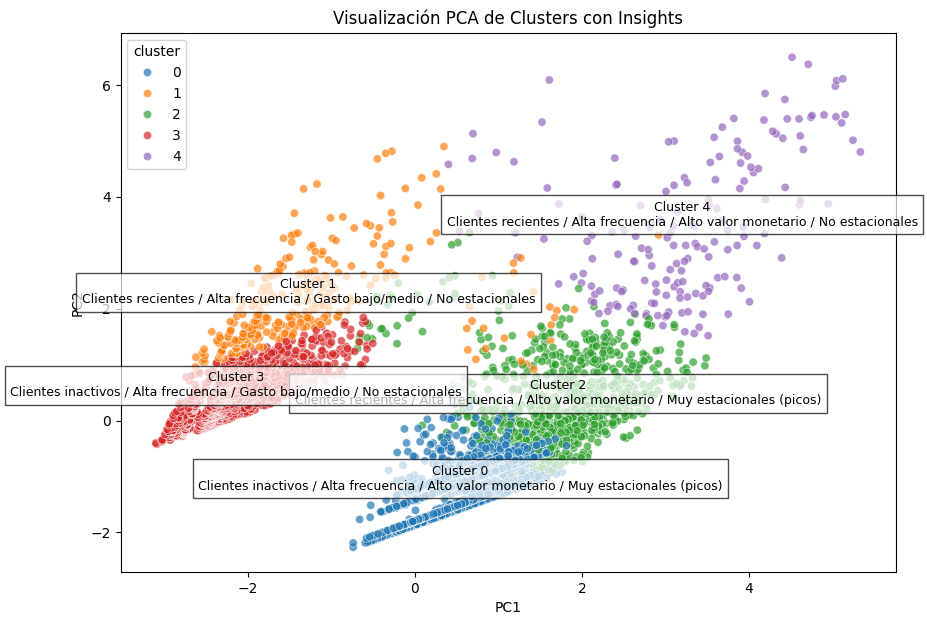

In [52]:
# ---------------------------------------------------------
# VISUALIZACIÓN DEL PCA CON ANOTACIONES
# ---------------------------------------------------------
plt.figure(figsize=(10,7))
sns.scatterplot(
    data=rfm_df, x='PC1', y='PC2',
    hue='cluster', palette='tab10', alpha=0.7
)

plt.title("Visualización PCA de Clusters con Insights")

# Añadir anotaciones por cluster
for c, desc in cluster_insights.items():
    cx = rfm_df[rfm_df['cluster']==c]['PC1'].mean()
    cy = rfm_df[rfm_df['cluster']==c]['PC2'].mean()

    plt.text(
        cx, cy,
        f"Cluster {c}\n{desc}",
        fontsize=9,
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="black"),
        ha='center'
    )

plt.show()

/tmp/ipython-input-3658647756.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=rfm_df, x=var, hue='cluster', common_norm=False, fill=True)


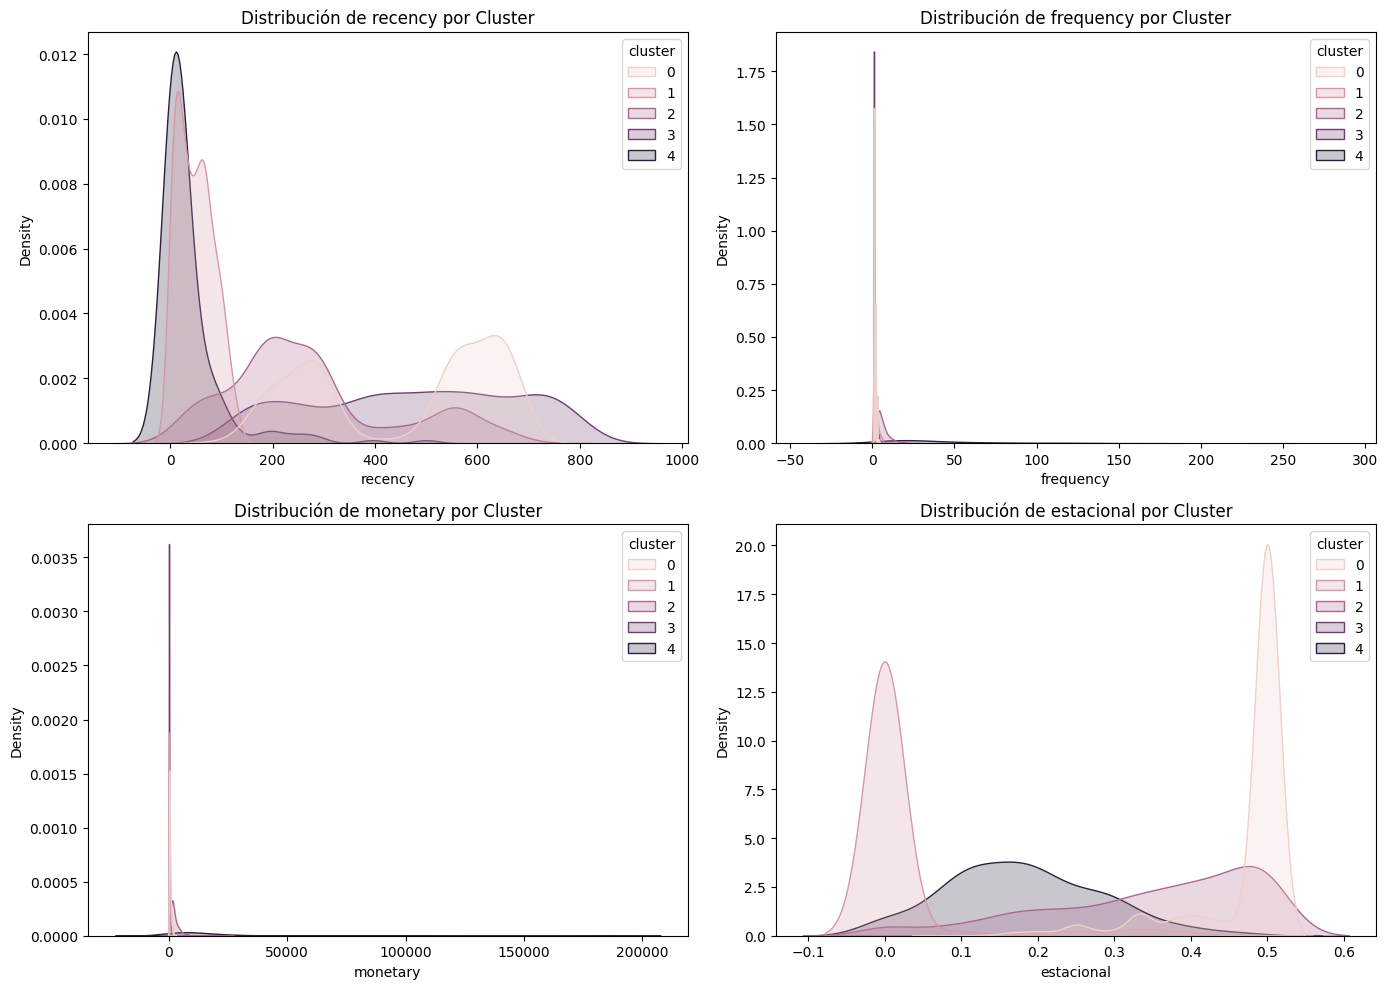

In [53]:
# ---------------------------------------------------------
# Boxplots comparativos por cluster (RFM + estacionalidad)
# ---------------------------------------------------------
plt.figure(figsize=(14,10))

for i, var in enumerate(['recency','frequency','monetary','estacional']):
    plt.subplot(2,2,i+1)
    sns.kdeplot(data=rfm_df, x=var, hue='cluster', common_norm=False, fill=True)
    plt.title(f"Distribución de {var} por Cluster")

plt.tight_layout()
plt.show()


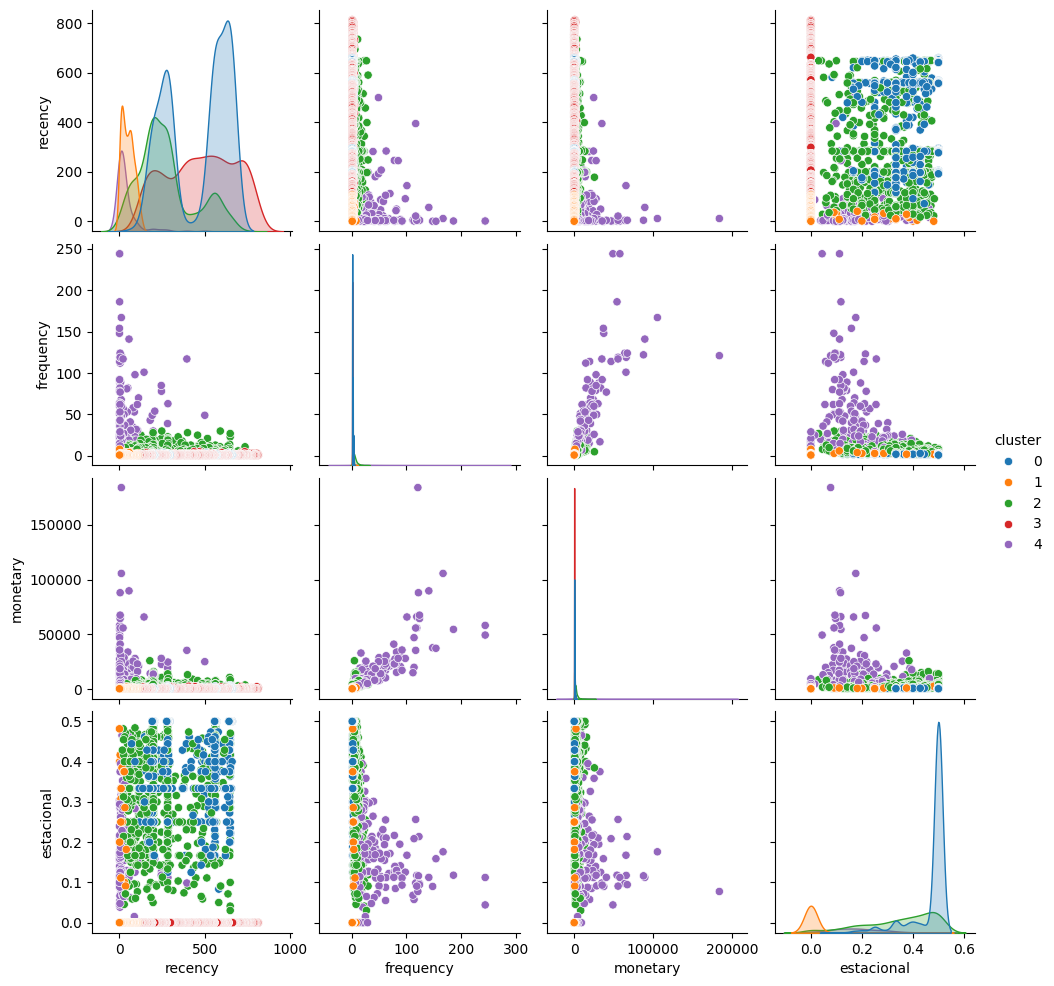

In [54]:
# ---------------------------------------------------------
# Pairplot (scatter matrix) coloreado por cluster
# ---------------------------------------------------------
sns.pairplot(
    rfm_df[['recency','frequency','monetary','estacional','cluster']],
    hue='cluster',
    diag_kind='kde',
    palette='tab10'
)
plt.show()

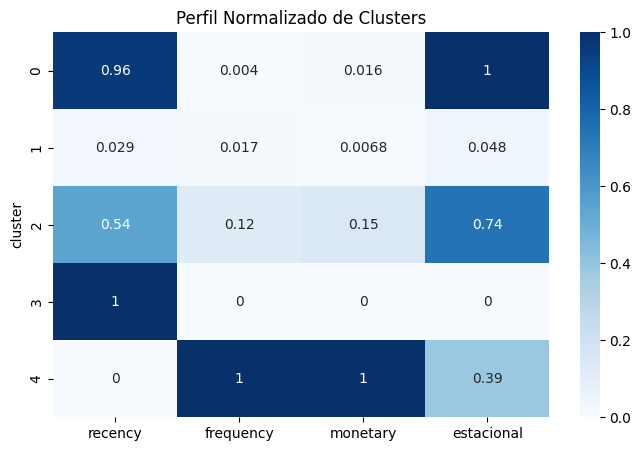

In [55]:
# ---------------------------------------------------------
# Agrupación normalizada Heatmap de medias normalizadas por cluster — PERFIL DE CLUSTER
# ---------------------------------------------------------
cluster_profile = (
    rfm_df.groupby("cluster")[["recency","frequency","monetary","estacional"]]
    .mean()
)

cluster_profile_norm = (cluster_profile - cluster_profile.min()) / (cluster_profile.max() - cluster_profile.min())

plt.figure(figsize=(8,5))
sns.heatmap(cluster_profile_norm, annot=True, cmap="Blues")
plt.title("Perfil Normalizado de Clusters")
plt.show()

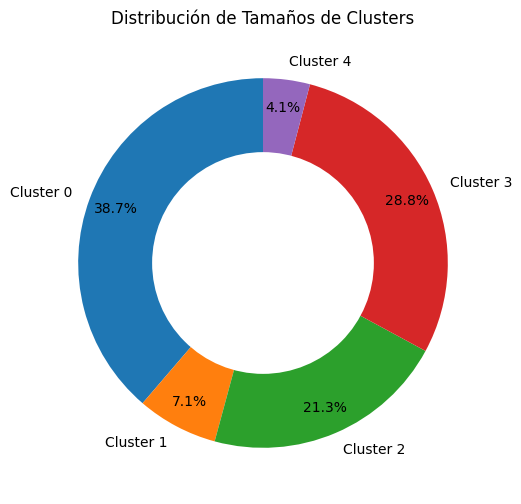

In [56]:
# ---------------------------------------------------------
# Donut chart del tamaño de cada cluster
# ---------------------------------------------------------
cluster_counts = rfm_df['cluster'].value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(
    cluster_counts,
    labels=[f"Cluster {i}" for i in cluster_counts.index],
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85
)

# círculo central
centre = plt.Circle((0,0),0.60,fc='white')
plt.gca().add_artist(centre)

plt.title("Distribución de Tamaños de Clusters")
plt.show()


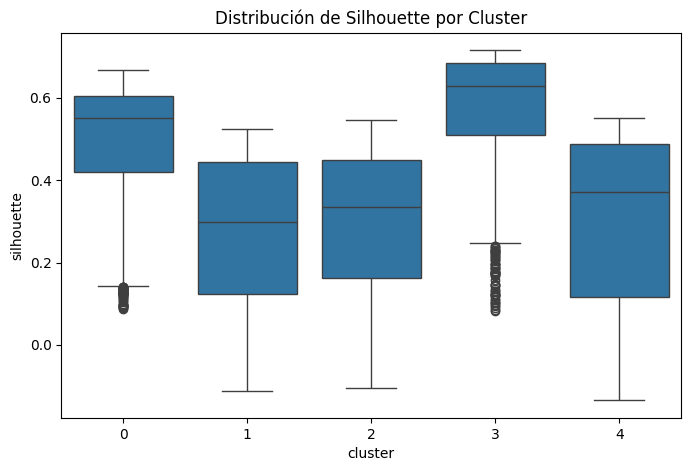

In [57]:
# ---------------------------------------------------------
# Radar Chart (Spider Plot) por cluster
# ---------------------------------------------------------
variables = ["recency","frequency","monetary","estacional"]
N = len(variables)

cluster_means = rfm_df.groupby("cluster")[variables].mean()

#Silhouette Plot (calidad de clustering)
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

sil_values = silhouette_samples(X, rfm_df['cluster'])
rfm_df['silhouette'] = sil_values

plt.figure(figsize=(8,5))
sns.boxplot(data=rfm_df, x='cluster', y='silhouette')
plt.title("Distribución de Silhouette por Cluster")
plt.show()



### **11. Inserción de Resultados**

In [96]:
import json
final_df = rfm_df[['cliente_id','cluster','Cluster_Name']].rename(columns={'Cluster_Name':'cluster_descipcion'})
final_json = final_df.to_dict(orient="records")

data = {
    'data': final_json
}

data = json.dumps(data, indent=4)
print (data)


{
    "data": [
        {
            "cliente_id": 2,
            "cluster": 3,
            "cluster_descipcion": "Clientes Inactivos"
        },
        {
            "cliente_id": 3,
            "cluster": 3,
            "cluster_descipcion": "Clientes Inactivos"
        },
        {
            "cliente_id": 4,
            "cluster": 3,
            "cluster_descipcion": "Clientes Inactivos"
        },
        {
            "cliente_id": 8,
            "cluster": 0,
            "cluster_descipcion": "Clientes Estacionales"
        },
        {
            "cliente_id": 11,
            "cluster": 0,
            "cluster_descipcion": "Clientes Estacionales"
        },
        {
            "cliente_id": 15,
            "cluster": 0,
            "cluster_descipcion": "Clientes Estacionales"
        },
        {
            "cliente_id": 18,
            "cluster": 0,
            "cluster_descipcion": "Clientes Estacionales"
        },
        {
            "cliente_id": 26,
            